# Exploratory Data Analysis of Mental Health in the Tech Industry

## 1. Goal of the analysis

### 1.1 The primary goal of this analysis is to explore mental health trends in the tech industry. This includes identifying key patterns, examining employer-provided mental health resources, assessing the prevalence of mental health issues, and understanding attitudes toward mental health compared to physical health. By addressing these aspects, the analysis aims to uncover actionable insights for improving mental health awareness and support in the workplace.

### 1.2 This EDA will focus on several key objectives:
1. **Sampling Bias:**
- **Hypothesis**: The dataset may not represent the broader population, with potential biases in age, gender and race.
2. **Mental Health Resources Over Time:**
- **Hypothesis**: Current employers have increased mental health resources over time, while previous employers have not shown substantial improvement.
3. **Prevalence of Most Common Mental Health Issues:**
- **Hypothesis**: Mental health issues such as mood disorders, anxiety disorders, and ADHD may be common within high-stress environments like the tech industry.
4. **Mental Health vs. Physical Health:**
- **Hypothesis**: Employers prioritize physical health more than mental health, but attitudes toward mental health are improving.

### 1.3 First, we import the main libraries and create a consistent visual colormap we will use for the analysis.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3
from src.utilities import (create_age_histplot, create_lineplot,
                           create_gender_barplot, create_prevalence_barplot,
                           create_correlation_heatmap, create_violin_subplots,
                           find_outliers)

In [2]:
pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.figsize'] = (10, 6)
colors=["#ca0020", "#f4a582", "#92c5de", "#0571b0"]
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(colors))

### 1.4 Now, we make a SQL query and use it to load the dataset into a dataframe

In [3]:
con = sqlite3.connect("mental_health.sqlite")
query = """
SELECT a.SurveyID,
    CASE
        WHEN q.QuestionID = 96 THEN 16
        WHEN q.QuestionID = 104 THEN 98
        ELSE q.QuestionID
    END AS QuestionID,
    CASE
        WHEN q.QuestionID = 16 THEN 'Does your employer provide resources to learn more about mental health issues and how to seek help?'
        WHEN q.QuestionID = 98 THEN 'Do you think that discussing a mental health disorder with your employer would have negative consequences?'
        ELSE q.QuestionText
    END AS QuestionText,
    a.UserID,
    CASE
        WHEN q.QuestionID IN (91,108,109,111) AND a.AnswerText IN ('I don''t know','Don''t know') THEN NULL
        WHEN a.AnswerText = 'I don''t know' THEN 'Don''t know'
        WHEN a.AnswerText IN ('None did','No, none did') THEN 'No'
        WHEN a.AnswerText = 'Yes, they all did' THEN 'Yes'
        WHEN q.QuestionID = 2 AND a.AnswerText NOT IN ('Male','Female') THEN 'Other'
        WHEN q.QuestionID IN (10,15,16,23,25,26,64,65,76,77,104,90,91,108,109,111,115) AND a.AnswerText = "-1" THEN NULL
        ELSE a.AnswerText
    END AS AnswerText
FROM answer a
JOIN question q
    ON q.questionid = a.questionid
ORDER BY 1, 2
"""
df = pd.read_sql_query(query, con)
df.head()

,SurveyID,QuestionID,QuestionText,UserID,AnswerText
0,2014,1,What is your age?,1,37
1,2014,1,What is your age?,2,44
2,2014,1,What is your age?,3,32
3,2014,1,What is your age?,4,31
4,2014,1,What is your age?,5,31


## 2. Data cleaning

### 2.1 We check for any missing values

In [4]:
zeroes = (df == 0).sum()
empty_strings = (df.replace(r"^\s*$", "", regex=True) == "").sum()
nas = df.isna().sum()
combined_counts = pd.DataFrame({
    "Zeroes": zeroes,
    "Empty Strings": empty_strings,
    "NaN": nas
    })
combined_counts

,Zeroes,Empty Strings,NaN
SurveyID,0,0,0
QuestionID,0,0,0
QuestionText,0,0,0
UserID,0,0,0
AnswerText,0,25,7391


There are plenty of NaN's since we did clean a lot of data with no answers (-1). But we also see 25 answers with empty text, let's inspect them:

In [5]:
empty_string_df = (df[df["AnswerText"].replace(r"^\s*$", "", regex=True) == ""]
                   .groupby("QuestionID",)
                   .apply(lambda x: x, include_groups=False)
                   .reset_index()
                   .drop(columns="level_1")
                   )
empty_string_df

,QuestionID,SurveyID,QuestionText,UserID,AnswerText
0,61,2017,Describe the conversation with coworkers you had about your mental health including their reactions.,2716,\n
1,61,2019,Describe the conversation with coworkers you had about your mental health including their reactions.,4072,\n
2,63,2017,Describe the conversation your coworker had with you about their mental health (please do not use names).,3203,\n
3,63,2019,Describe the conversation your coworker had with you about their mental health (please do not use names).,4072,\n
4,63,2019,Describe the conversation your coworker had with you about their mental health (please do not use names).,4094,\n
5,86,2017,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,2855,\n
6,86,2017,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,2994,\n
7,86,2019,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,4006,\n
8,86,2019,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,4072,\n
9,86,2019,Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.,4094,\n


It seems like these are open questions, with most of them being related to improving the survey itself. Therefore, we can expect some people not to answer them.

### 2.2 Let's check for duplicate entries

In [6]:
print(f"There are {df.duplicated().sum()} duplicate rows.")

There are 0 duplicate rows.


### 2.3 We can take a look at the questions of the survey itself

In [7]:
unique_questions = df[['QuestionID', 'QuestionText']].drop_duplicates().sort_values('QuestionID')
question_list = unique_questions.values.tolist()
for question_id, question_text in question_list:
    print(f"{question_id}: {question_text}")

1: What is your age?
2: What is your gender?
3: What country do you live in?
4: If you live in the United States, which state or territory do you live in?
5: Are you self-employed?
6: Do you have a family history of mental illness?
7: Have you ever sought treatment for a mental health disorder from a mental health professional?
8: How many employees does your company or organization have?
9: Is your employer primarily a tech company/organization?
10: Does your employer provide mental health benefits as part of healthcare coverage?
11: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12: Would you bring up a mental health issue with a potential employer in an interview?
13: Is your primary role within your company related to tech/IT?
14: Do you know the options for mental health care available under your employer-provided health coverage?
15: Has your employer ever formally discussed mental hea

It seems like there is a vast amount of questions regarding physical health and mental health, with quite a few questions focusing on either current or previous employer's standpoint. We will use these questions for our analysis later on.

### 2.4 What's our sample size?

In [8]:
respondents = len(df["UserID"].unique())
print(f"In total there were {respondents} respondents.")

In total there were 4218 respondents.


### 2.5 We check for any outliers in the numeric columns

In [9]:
numeric = [feature for feature in df if df[feature].dtype in ["int64","float64"]]
outliers = find_outliers(df,numeric)
print(f"Outliers:\n{outliers}")

Unique outliers in 'SurveyID': [2014, 2019]
No outliers in 'QuestionID'
No outliers in 'UserID'
Outliers:
[2014, 2019]


It seems like our SurveyID column showing survey years has the years 2014 and 2019 as outliers. To understand that, we can look at the sample distribution by year.

In [10]:
df.groupby("SurveyID")["UserID"].nunique()

SurveyID
2014    1260
2016    1433
2017     756
2018     417
2019     352
Name: UserID, dtype: int64

It seems like 2014 and 2016 had the highest participation, with the numbers going down each year. 2014 and 2019 are flagged as outliers because their participation counts deviate significantly from the general trend in the dataset.

## 3. Sampling bias

### 3.1 To look for sampling bias, let's first inspect the response distribution by year, by age

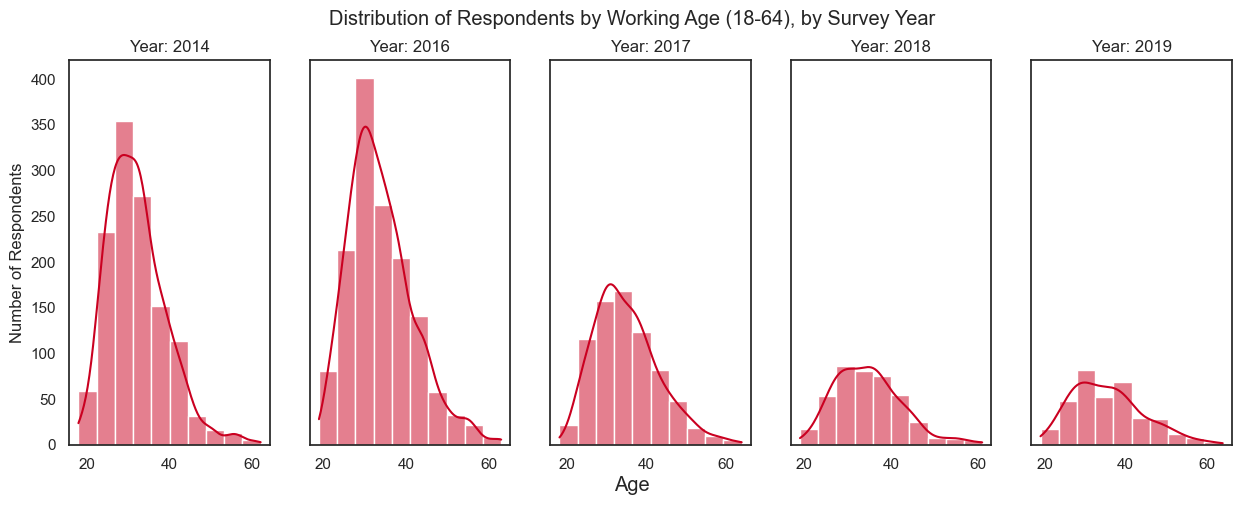

In [11]:
create_age_histplot(df)

We can clearly see that the first 2 years of our dataset had way more respondents. Furthermore, all of these distributions seem unimodal, slightly skewed to the right, centered at about 30 years, with most data being between 25 and 50 years, with fewer respondents at the extremes (younger than 20 or older than 60). This could stem from the fact that the online survey itself is open to everyone, and older age groups might be more difficult to reach.

### 3.2 We can look at the distribution of genders by survey year

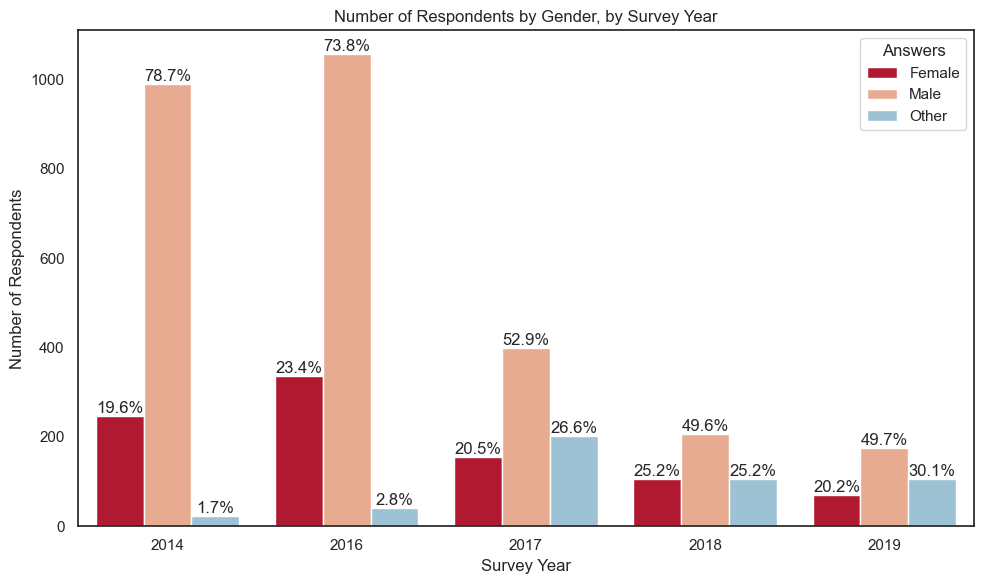

In [12]:
create_gender_barplot(df)

There's a clear difference between the male and female distribution - males seem to appear ~2.5x more often than females in the sample. After referring to data from **U.S. Equal Employment Opportunity Commission**, we can determine that this is the right representation - women seem to only take about 20-30% of the technical positions. Lastly, the "Other" category grows significantly over time, from 1.7% in 2014 to a substantial 30.1% in 2019. This trend might suggest improved inclusivity of other gender identities in the survey, or a cultural shift encouraging individuals to self-identify beyond the traditional binary genders.

### 3.3 Let's check the distribution of races within the survey

In [13]:
race_df = df[df["QuestionID"] == 89]["AnswerText"].value_counts()
race_df

AnswerText
White                               873
-1                                  537
More than one of the above           35
Asian                                31
I prefer not to answer               29
Black or African American            15
American Indian or Alaska Native      1
Hispanic                              1
White Hispanic                        1
European American                     1
Caucasian                             1
Name: count, dtype: int64

"White" is the majority group, having 873 respondents, which is significantly higher than any other category. This indicates a strong predominance of individuals identifying as White in the survey. A notable number of respondents (573) chose to not answer the question.
Some smaller groups (Mixed, Asian, Black or African American) have a small representation in the dataset, while some categories have only 1 respondent each.

This indicates, according to our dataset, that while "White" dominates the data, there is a small contribution from other diverse groups.
Furthermore, if more corespondents responded with their race, we might see more contribution from the minority groups.

### We can determine that the dataset has sample bias, as the information is collected from an open survey, with very varied response rates over years. Therefore the analysis results should not be taken with a high confidence rate for the general population.

## 4. Availability of mental health resources over the years

### 4.1 Let's see whether resources about mental health issues offered by employers has improved over time

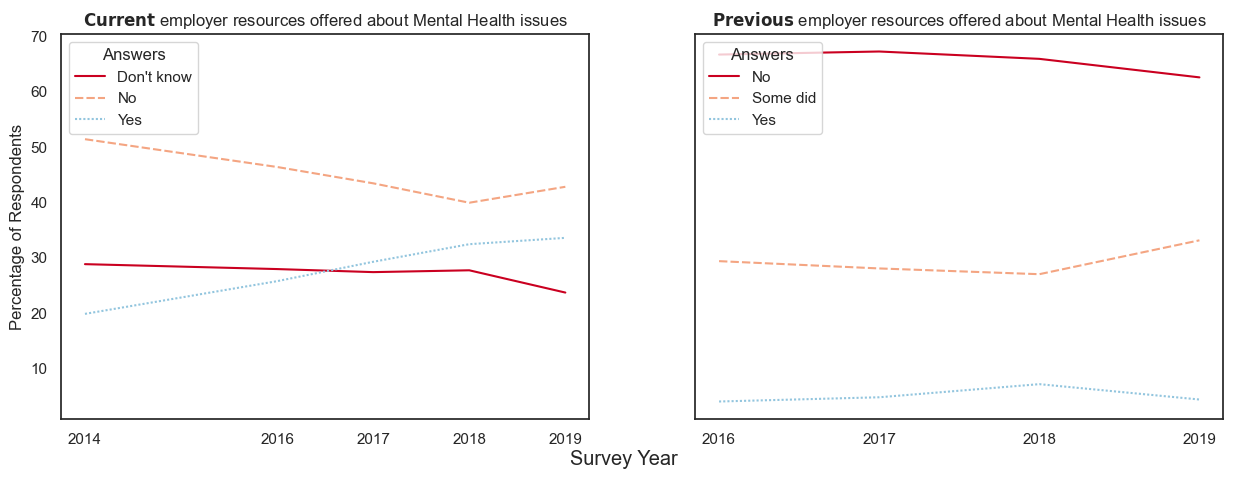

In [14]:
create_lineplot(df,[16,26],"resources offered about Mental Health issues")

We can see that the with respondents' current employers, there seem to be more resources provided as time passes. Furthermore, with previous employers, the lack of provided resources has a way higher percentage rate, and the positive change is very minor over time. This indicates that employees are leaving positions where the employer does not provide proper Mental Health issue resources and is not willing to improve on that over time.

### 4.2 We can also compare the mental health benefits provided by employers over time

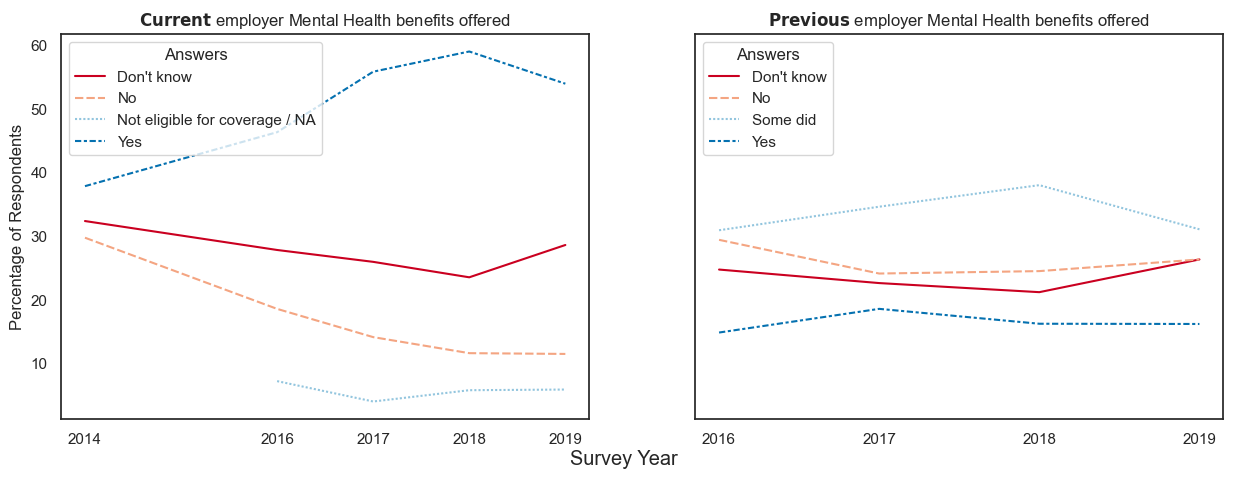

In [15]:
create_lineplot(df,[10,23],"Mental Health benefits offered")

It seems like there is a drastic **15-20%** difference between **2014** and **2019** in how many employers (current) started providing mental health benefits. As for previous employers, the rate of providing these benefits is considerably smaller, with slight improvement over the years but a sudden decrease in **2019**. This, once again, shows us that employees are not willing to stick working for employers that do not care about mental health.

### 4.3 Let's check whether employers tend to ever formally discuss mental health (for example, as part of a wellness campaign or other official communication)

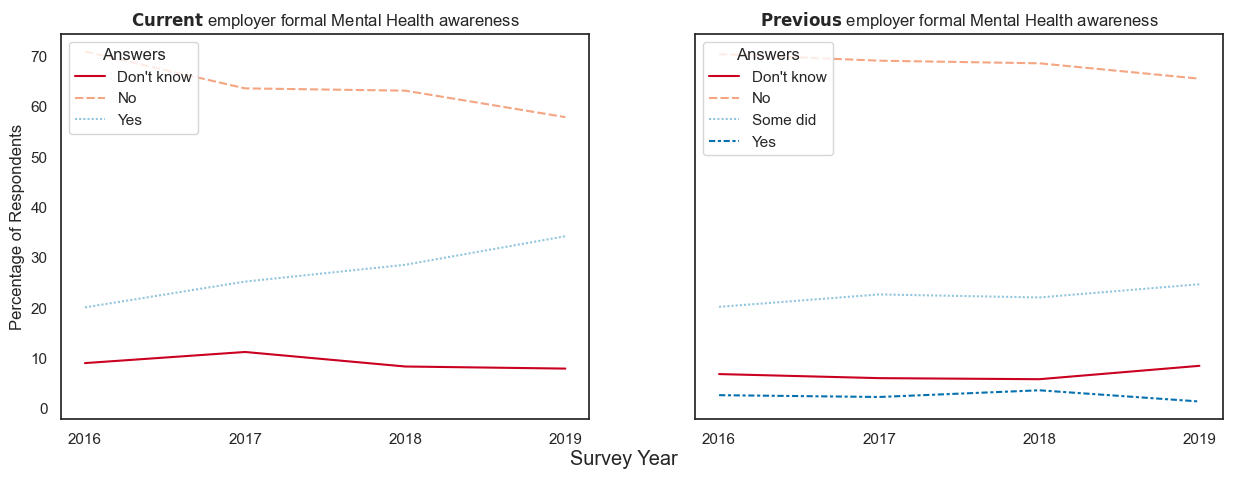

In [16]:
create_lineplot(df,[15,25],"formal Mental Health awareness")

Our previous trend follows, where we see that our respondents' current employers are really improving mental health importance over time and providing more awareness for it, going from **20%** to **30%** positive responses. Again, with the previous employers, there were basically no cases where they would provide any formal mental health awareness, and the case didn't get any significant improvement over time.

## 5. Prevalence rate of mental health issues

### 5.1 Let's check the prevalence rate of the 3 most common Mental Health issues within the dataset

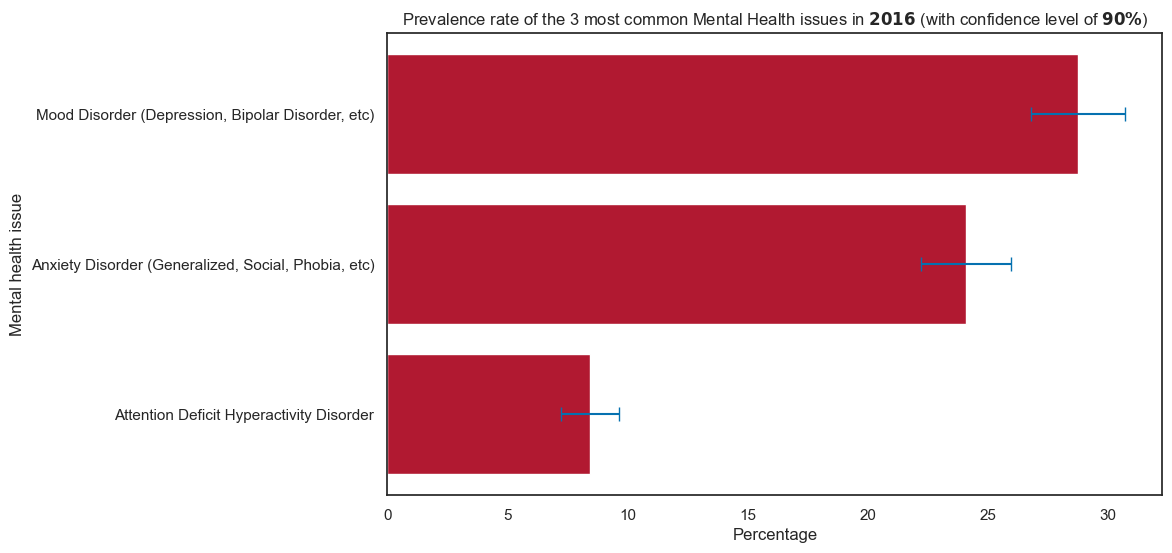

In [17]:
create_prevalence_barplot(df,34,115)

When taking the percentage of mental health issues from respondents that answered *Yes* to ever being officially diagnosed, we can see that the 3 most common mental health issues in **2016** were **Mood Disorder (CI between 27% and 31%), Anxiety Disorder (CI between 22% and 26%)** and **Attention Deficit Hyperactivity Disorder (ADHD) (CI between 7% and 9%)**. We are using a confidence level of **90%** as our data was obtained via non-probability sampling (open survey online). It does not involve random selection, therefore it is less likely to represent the general population.

## 6. Mental vs Physical Health importance

### 6.1 By using specific questions of interest, let's look at a correlation heatmap, alongside the questions we are inspecting

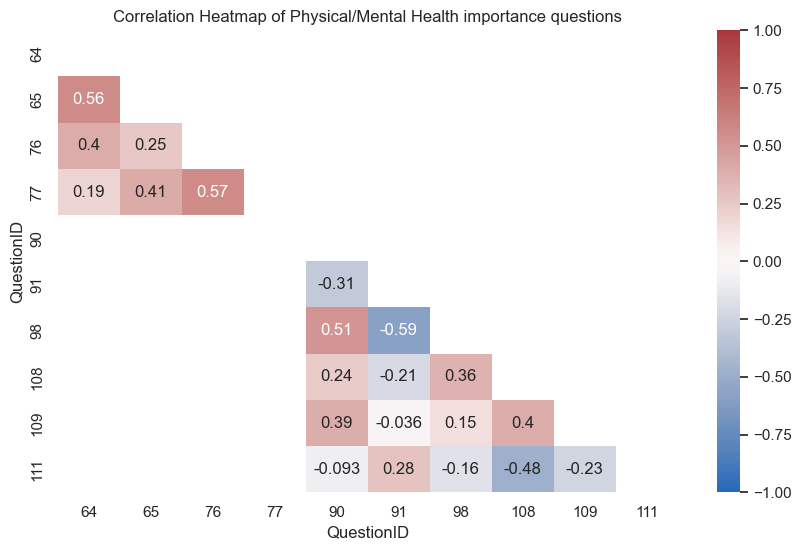

64: Overall, how much importance does your employer place on physical health?
65: Overall, how much importance does your employer place on mental health?
76: Overall, how much importance did your previous employer place on physical health?
77: Overall, how much importance did your previous employer place on mental health?
90: Do you think that discussing a physical health issue with your employer would have negative consequences?
91: Do you feel that your employer takes mental health as seriously as physical health?
98: Do you think that discussing a mental health disorder with your employer would have negative consequences?
108: Do you think that discussing a mental health disorder with previous employers would have negative consequences?
109: Do you think that discussing a physical health issue with previous employers would have negative consequences?
111: Did you feel that your previous employers took mental health as seriously as physical health?


In [18]:
questions_of_interest = [64,65,76,77,90,91,98,108,109,111]
filtered_df = df[df["QuestionID"].isin(questions_of_interest)]
pivoted_df = (filtered_df.pivot(index="UserID",
                                columns="QuestionID",
                                values="AnswerText"
                                )
                                .dropna(how="all")
            )

create_correlation_heatmap(pivoted_df)

for question_id in questions_of_interest:
    question_text = df.loc[df['QuestionID'] == question_id, 'QuestionText'].iloc[0]
    print(f"{question_id}: {question_text}")

We can see a missing block in the bottom-left corner, indicating that questions **64,65,76,77** were asked in different years than **90,91,98,108,109,111**, and therefore could not be correlated to each other.

1. **Strong negative correlation (Q98 and Q91)**:
- When employers treat mental health as seriously as physical health, employees report significantly fewer negative consequences for discussing mental health issues. This underscores the critical role of equal physical safety and openness about mental health.

2. **Moderate negative correlation (Q111 and Q108)**:
- The less seriously an employer treats mental health relative to physical health, the higher the likelihood of employees perceiving negative consequences for discussing mental health. This highlights the damaging impact of neglecting mental health in organizational culture.

3. **Strong positive correlation (Q65 and Q64)**:
- Employers prioritizing physical health are more likely to also prioritize mental health. This alignment suggests that organizations addressing both physical and mental well-being create a supportive environment for employees.

4. **Strong positive correlation (Q77 and Q76)**:
- This pattern extends to past employers, indicating a consistent relationship between valuing physical and mental health across workplaces.

5. **Strong positive correlation (Q98 and Q90)**:
- Suggests that employees who feel negative consequences for discussing physical health issues are likely to feel similarly about mental health. This could point to a culture of stigma or lack of support for health issues in general within certain workplaces.

### We will put short labels on these questions to make our further graphing more concise.

In [19]:
question_labels = {
    64: "Employer's focus on Physical Health",
    65: "Employer's focus on Mental Health",
    76: "Prev. employer's focus on Physical Health",
    77: "Prev. employer's focus on Mental Health",
    90: "Neg. impact of discussing Physical Health",
    98: "Neg. impact of discussing Mental Health",
    108: "Neg. impact of discussing Mental Health (Prev.)",
    109: "Neg. impact of discussing Physical Health (Prev.)",
    91: "Mental Health equally valued as Physical Health",
    111: "Mental Health equally valued as Physical Health (Prev.)"
}

### 6.2 Let's compare the current and previous employer's focus on Physical vs Mental Health

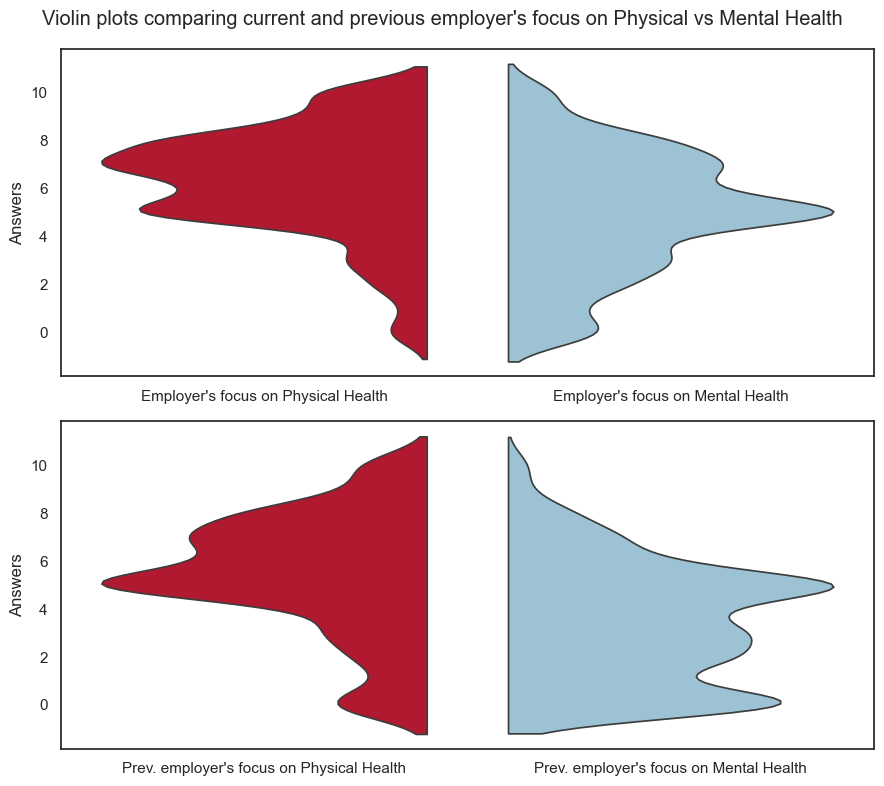

In [20]:
create_violin_subplots([(64,65),(76,77)],question_labels,pivoted_df,"Violin plots comparing current and previous employer's focus on Physical vs Mental Health")

For the current employer, the distributions seem to be unimodal. For physical health, most data is **between 4 and 9**, with **peaks at 5 and 7**. For mental health, most data is **between 2 and 8**, with **peak at 5**. So we can see that the physical health is taken slightly more seriously than mental health, but not by a substantial amount.

When comparing data about previous employers, for physical health we see a unimodal distribution with most data **between 3 and 8**, with a **peak at 5**. For mental health, we see a bimodal distribution with most data **between 0 and 6**, with **peaks at 5 and 0**. This indicates a huge issue, showing us that while previous employers gave less importance to physical health, their outlook on mental health was really negative.

### 6.3 We can now look at the Negative Impact when discussing Mental Health vs Physical health (comparing current and previous employers)

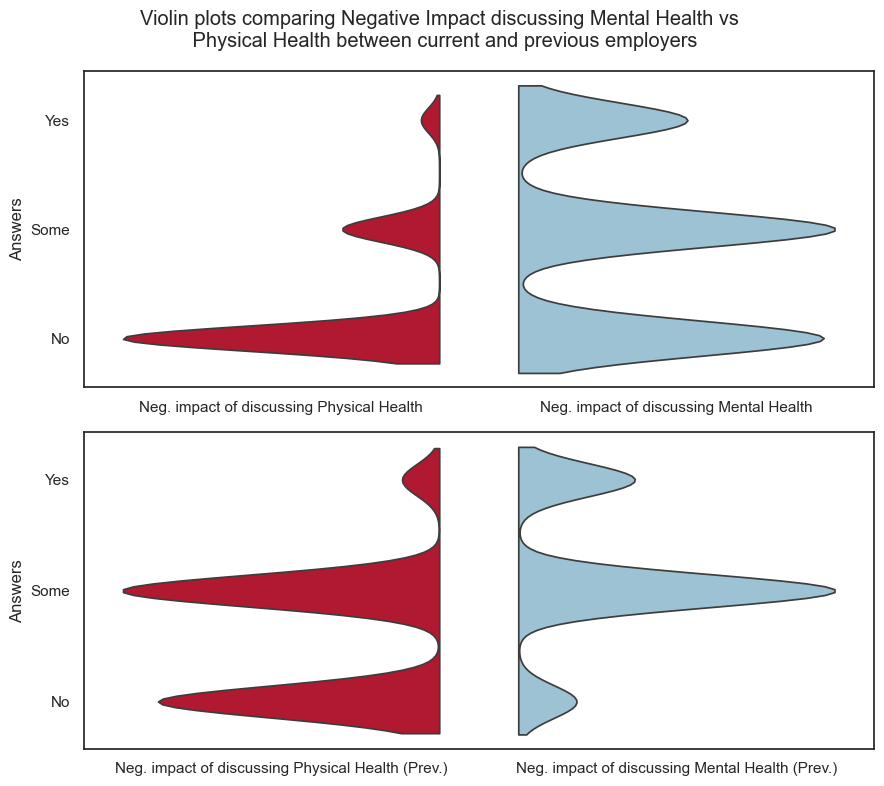

In [21]:
create_violin_subplots([(90,98),(109,108)],question_labels,pivoted_df,"Violin plots comparing Negative Impact discussing Mental Health vs \n Physical Health between current and previous employers")

For the current employer, most people would think that there wouldn't be any negative impact discussing physical health with their employer. However, for mental health, more people feel like there would be negative impact, with the majority split 50/50 between **some and none** negative impact.

For the previous employer, we already see a stronger negative skew when discussing physical health - most people say that **some** employers will not take that seriously. As for mental health, the vast distribution shifts to **some** as well, with more **yes** answers than **no**.

### 6.4 Lastly, we can compare whether employers see Mental Health as equally valued as Physical Health

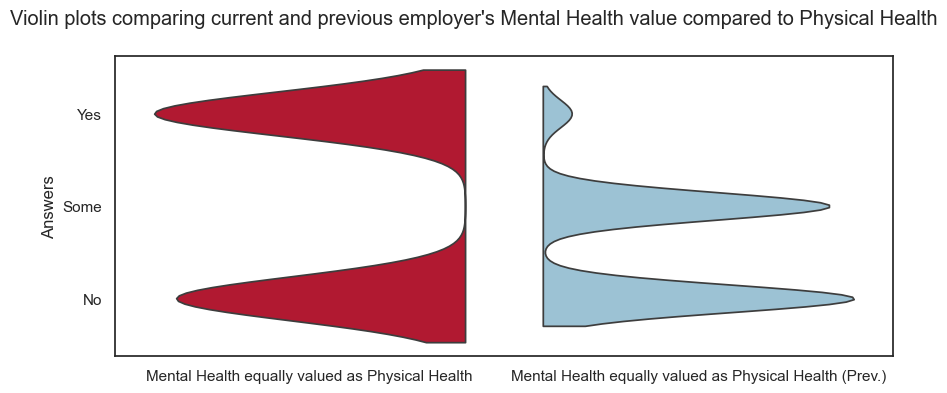

In [22]:
create_violin_subplots([(91,111)],question_labels,pivoted_df,"Violin plots comparing current and previous employer's Mental Health value compared to Physical Health")

There's almost a 50/50 distribution with employees considering their current employers to take mental health as seriously as physical health. However, with their past employers, the majority of **yes** votes go to **some**, indicating that most previous employers did not consider mental health to be as serious.

## 7. Conclusion

### Answers to Hypotheses:

1. **Sampling Bias**:
- *Age Distribution*: Respondents are primarily working-age adults (18-64), centered around 30 years old, with a slight right skew. Younger (<20) and older (>60) respondents are underrepresented.
- *Gender Representation*: Male respondents (~2.5x more than females) reflect the gender disparity in technical roles, as reported by the **U.S. Equal Employment Opportunity Commission**. The "Other" category saw a significant increase from 1.7% in 2014 to 30.1% in 2019, indicating growing inclusivity or cultural shifts in self-identification.
- *Race Representation*: White respondents dominate (873), while smaller groups (Mixed, Asian, Black) are underrepresented. A significant number (537) chose not to disclose their race, potentially masking minority contributions.
- **Conclusion**: as the data is from an open survey, the non-random sampling method may lead to some sampling bias. Therefore, results of the analysis using this dataset may not fully accurately represent the general population.

2. **Mental Health Resources Over Time**:
- Current employers have shown a consistent improvement in providing mental health benefits and formal awareness campaigns, with a notable increase of 15-20% in benefits from 2014 to 2019.
- Previous employers lag significantly, with limited improvement over time, suggesting that employees may leave workplaces that lack sufficient mental health resources.

3. **Prevalence of Most Common Mental Health Issues**:
- In 2016, Mood Disorder (27%-31%), Anxiety Disorder (22%-26%), and ADHD (7%-9%) were the most reported conditions among respondents diagnosed with a mental health issue. The confidence intervals are based on a 90% level, acknowledging potential bias due to non-random sampling.
- Mood and anxiety disorders point to emotional and stress-related challenges, while ADHD may reflect difficulties adapting to a fast-paced, multitasking environment. These insights can guide organizations to target mental health resources and workplace interventions toward these common conditions.

4. **Mental Health vs. Physical Health**:
- Correlation Findings:
  - Strong positive correlations indicate that employers who prioritize physical health also tend to value mental health.
  - Negative correlations show that when employers take mental health seriously, employees report fewer negative consequences for discussing these issues.
- Distribution Findings:
  - Current employers take physical health slightly more seriously than mental health, but the gap is narrowing.
  - Previous employers showed significant neglect of mental health, with bimodal distributions indicating polarized attitudes.

## 8. Future improvements

1. **Address Sampling Bias**:
- Recruit a more diverse group of respondents, particularly from underrepresented races and gender groups, to improve the dataset's representativeness.
- Target outreach to older professionals in tech to ensure better age representation.

2. **Expand Longitudinal Analysis**:
- Incorporate data beyond 2019 to observe trends in mental health awareness and resource allocation in the tech industry.


3. **Enhance Statistical Analysis**:
- Apply weighting techniques to adjust for biases and improve the validity of findings.

4. **Improved Race Data**:
- Encourage respondents to disclose their race to better understand diversity within the tech industry and its impact on mental health trends.